# MGCosmoPop

This notebook shows how to use MGCosmoPop to sample from mass and redshift distributions, load GWTC-2 data, and compute posterior probabilities for astrophysical and cosmological parameters.

In [1]:

import os
import sys
sys.path.append( os.path.join(os.path.dirname(os.path.realpath("__file__")), '../'))
import importlib
import numpy as np
import scipy.stats as ss
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import corner

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

import Globals

# Population

A population is characterised by three components: 
* the mass distribution of the binaries, $p(m_1, m_2)$, implemented in population.astro.astroMassDistribution
* the distribution of the spins of the binaries, implemented in population.astro.astroSpinDistribution
* the evolution of the merger rate of the binaries with redshift, $\frac{d R}{dV_c dt} = R(z)$, implemented in population.astro.rateEvolution


A *population* is another separate class, that is instantiated by passing as arguments a mass distribution, spin distribution, and rate

Finally, allPopulation is an object that collects all populations and the cosmology and returns the (log) differential number of events per unit mass, distance and redshift (or det frame masses and luminosity distance) 



## 1. Instantiate a mass function

Supported:
* truncated power law
* broken power law
* (truncated power law with smoothed edges)

In [2]:
from population.astro.astroMassDistribution import BrokenPowerLawMass, PowerLawPlusPeakMass

In [3]:
massFunction = PowerLawPlusPeakMass() 
#BrokenPowerLawMass( )

 Power law + peak mass function base values: {'lambdaPeak': 0.03, 'beta': 0.81, 'alpha': 3.78, 'deltam': 4.8, 'ml': 5.0, 'mh': 112.0, 'muMass': 32.0, 'sigmaMass': 3.88}


## 2. Instantiate spin distribution

For skipping the spin distribution, we use the class DummySpinDist.

A gaussian distribution for the components $\chi_p , \chi_{eff}$ is also supported.

In [4]:
from population.astro.astroSpinDistribution import DummySpinDist

# this skips spin distribution
spinDist = DummySpinDist()


## 3. Instantiate rate evolution objects

Supported: 

- simple power law: $R(z)=R_0 (1+z)^{\lambda}$

- Madau-Dickinson Rate

In [5]:
from population.astro.rateEvolution import AstroPhRateEvolution

In [6]:
MDrate = AstroPhRateEvolution() # Madau-Dickinson Rate

Rate R0 is in yr^-1 Gpc^-3


## 4. Create an Astrophysical Population for each mass funtion and rate


In [7]:
from population.astro.astroPopulation import AstroPopulation

In [8]:
MDpop = AstroPopulation(MDrate, massFunction, spinDist)

# Cosmology 

Then, one needs to define a cosmology. This is done via the *Cosmo* object, that contains all the useful functions


In [9]:
from cosmology.cosmo import Cosmo
import astropy.units as u

In [10]:
myCosmo = Cosmo(dist_unit=u.Gpc)

# All populations 

Different populations can be put together to give the final number of compact binaries. The object taking care of this is *AllPopulations* . 

It is instantiated by passing a cosmology (i.e. an instance of the *Cosmo* class). 

Then, each population is added through the method *add_pop* .


This class allows to calculate $\frac{d N}{dm_1^{d} dm_2^{d} d(dL)} = \frac{d N}{dm_1 dm_2 dz}\frac{1}{(1+z) \frac{d(dL)}{dz}}  = \frac{1}{(1+z) \frac{d(dL)}{dz}} \frac{d V_c}{dz}\frac{1}{(1+z)} R(z) p(s_1, s_2)  p(m_1, m_2)  $


In [11]:
from population.allPopulations import AllPopulations

In [12]:
allPopsMD = AllPopulations(myCosmo)

Setting cosmology.
5 parameters: ['H0', 'Om', 'w0', 'Xi0', 'n']


In [13]:
allPopsMD.add_pop(MDpop)

Adding population of type AstroPopulation
12 parameters: ['R0', 'alphaRedshift', 'betaRedshift', 'zp', 'lambdaPeak', 'alpha', 'beta', 'deltam', 'ml', 'mh', 'muMass', 'sigmaMass']
New parameter list: ['H0', 'Om', 'w0', 'Xi0', 'n', 'R0', 'alphaRedshift', 'betaRedshift', 'zp', 'lambdaPeak', 'alpha', 'beta', 'deltam', 'ml', 'mh', 'muMass', 'sigmaMass']. Total 17 params


### Set parameters values

Finally, one can change the values of the population parameters. 

In [14]:
myParams = { 'R0':20, 'alphaRedshift':3,  'betaRedshift':4, 'zp':2,  # rate
                    'lambdaPeak':0.1, 'alpha':2.62, 'beta':1.26, 
                'deltam':4.88, 'ml':4.53, 'mh':86.73, 'muMass':33.49, 'sigmaMass':1,
           }

In [15]:
allPopsMD.set_values( myParams)#{'R0':50, 'alphaRedshift':0,  'betaRedshift':2, 'zp':2 })

cosmo basevalues: {'H0': 67.74, 'Om': 0.3075, 'w0': -1, 'Xi0': 1, 'n': 1.91}
Setting values in populations...
Setting value of R0 to 20 in AstroPhRateEvolution
Setting value of alphaRedshift to 3 in AstroPhRateEvolution
Setting value of betaRedshift to 4 in AstroPhRateEvolution
Setting value of zp to 2 in AstroPhRateEvolution
Setting value of lambdaPeak to 0.1 in PowerLawPlusPeakMass
Setting value of alpha to 2.62 in PowerLawPlusPeakMass
Setting value of beta to 1.26 in PowerLawPlusPeakMass
Setting value of deltam to 4.88 in PowerLawPlusPeakMass
Setting value of ml to 4.53 in PowerLawPlusPeakMass
Setting value of mh to 86.73 in PowerLawPlusPeakMass
Setting value of muMass to 33.49 in PowerLawPlusPeakMass
Setting value of sigmaMass to 1 in PowerLawPlusPeakMass
Setting value of R0 to 20 in AstroPopulation
Setting value of alphaRedshift to 3 in AstroPopulation
Setting value of betaRedshift to 4 in AstroPopulation
Setting value of zp to 2 in AstroPopulation
Setting value of lambdaPeak to 0

### Visualise names and values of the population parameters

In [16]:
# Parameters' names 
allPopsMD.params

['H0',
 'Om',
 'w0',
 'Xi0',
 'n',
 'R0',
 'alphaRedshift',
 'betaRedshift',
 'zp',
 'lambdaPeak',
 'alpha',
 'beta',
 'deltam',
 'ml',
 'mh',
 'muMass',
 'sigmaMass']

In [17]:
# Values of the population parameters
lambdaBase = allPopsMD.get_base_values(allPopsMD.params)
lambdaBase

[67.74,
 0.3075,
 -1,
 1,
 1.91,
 20,
 3,
 4,
 2,
 0.1,
 2.62,
 1.26,
 4.88,
 4.53,
 86.73,
 33.49,
 1]

# Sampling

We can sample from the mass and redshift distributions with the .sample method of the object allPopulations.

In [22]:
N=20000
zmax = 20

In [23]:
massSamples, zsMD, _ = allPopsMD.sample(N, zmax, lambdaBase)
m1sMD, m2sMD = np.squeeze(massSamples)[:, 0], np.squeeze(massSamples)[:, 1]


Cosmo params in _sample_redshift: [67.74, 0.3075, -1]


### Redshift distribution

/Users/mancarel/Dropbox/Local/Physics_projects/MGCosmoPop/MGCosmoPop/notebooks/../cosmology/cosmo.py:116: RuntimeWarning: divide by zero encountered in log
  res =  np.log(4*np.pi)+3*np.log(self.clight)-3*np.log(H0)+2*np.log(self.uu(z, Om0, w0))-np.log(self.E(z, Om0, w0))


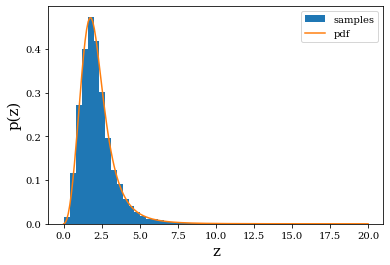

In [24]:
_ = plt.hist(zsMD, bins=50, density=True, label='samples')


R0, al, bb, zp, = allPopsMD.get_base_values(['R0', 'alphaRedshift', 'betaRedshift', 'zp', ])
H0, Om, w0 = allPopsMD.get_base_values(['H0', 'Om', 'w0',  ])



zz = np.linspace(0, zmax, 200)
zpdf = np.exp(allPopsMD._pops[0].rateEvol.log_dNdVdt(zz,  [R0, al, bb, zp,])+ allPopsMD.cosmo.log_dV_dz(zz, H0, Om, w0)-np.log1p(zz))
zpdf/=np.trapz(zpdf,zz)
plt.plot(zz, zpdf, label='pdf')

plt.xlabel('z', fontsize=15);
plt.ylabel('p(z)', fontsize=15);
plt.legend();

### Joint and marginal mass distribution

In [26]:

lambdaPeak, alpha, beta, deltam, ml, mh, muMass, sigmaMass = allPopsMD.get_base_values(['lambdaPeak', 'alpha', 'beta','deltam', 'ml', 'mh', 'muMass', 'sigmaMass' ])
print(lambdaPeak, alpha, beta, deltam, ml, mh, muMass, sigmaMass)


def pp_norm(x1, x2):
    return np.exp(allPopsMD._pops[0].massDist.logpdf([x1, x2], [lambdaPeak, alpha, beta, deltam, ml, mh, muMass, sigmaMass],  ))


0.1 2.62 1.26 4.88 4.53 86.73 33.49 1


In [27]:
# use this instead of the above for broken power law
'''
alpha1, alpha2, beta, deltam, ml, mh, b = allPopsMD.get_base_values(['alpha1', 'alpha2', 'beta', 'ml', 'mh', 'b', 'deltam'])
print(alpha1, alpha2, beta, ml, mh, b, deltam)


def pp_norm(x1, x2):
    return np.exp(allPopsMD._pops[0].massDist.logpdf([x1, x2], [alpha1, alpha2, beta, deltam, ml,  mh, b],  ))
'''

"\nalpha1, alpha2, beta, deltam, ml, mh, b = allPopsMD.get_base_values(['alpha1', 'alpha2', 'beta', 'ml', 'mh', 'b', 'deltam'])\nprint(alpha1, alpha2, beta, ml, mh, b, deltam)\n\n\ndef pp_norm(x1, x2):\n    return np.exp(allPopsMD._pops[0].massDist.logpdf([x1, x2], [alpha1, alpha2, beta, deltam, ml,  mh, b],  ))\n"

0.9999925206306284

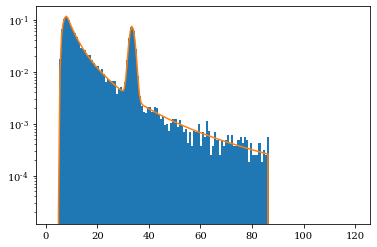

In [28]:
# Check m1 samples and pdf normalization

_ = plt.hist(m1sMD, bins=100, density=True, label='samples', )

mmm = np.linspace(2, 120, 200)
pdfm1 = np.exp(allPopsMD._pops[0].massDist._logpdfm1(mmm ,lambdaPeak, alpha, deltam, ml, mh, muMass, sigmaMass)-allPopsMD._pops[0].massDist._logNorm( lambdaPeak, alpha, deltam, ml, mh, muMass, sigmaMass  , res=1000))
    
#pdfm1 = np.exp(allPopsMD._pops[0].massDist._logpdfm1(mmm ,alpha1, alpha2, deltam, ml, mh, b)-allPopsMD._pops[0].massDist._logNorm( alpha1, alpha2, deltam, ml, mh, b , res=500))


    
plt.plot(mmm, pdfm1)
plt.yscale('log')

np.trapz(pdfm1, mmm)

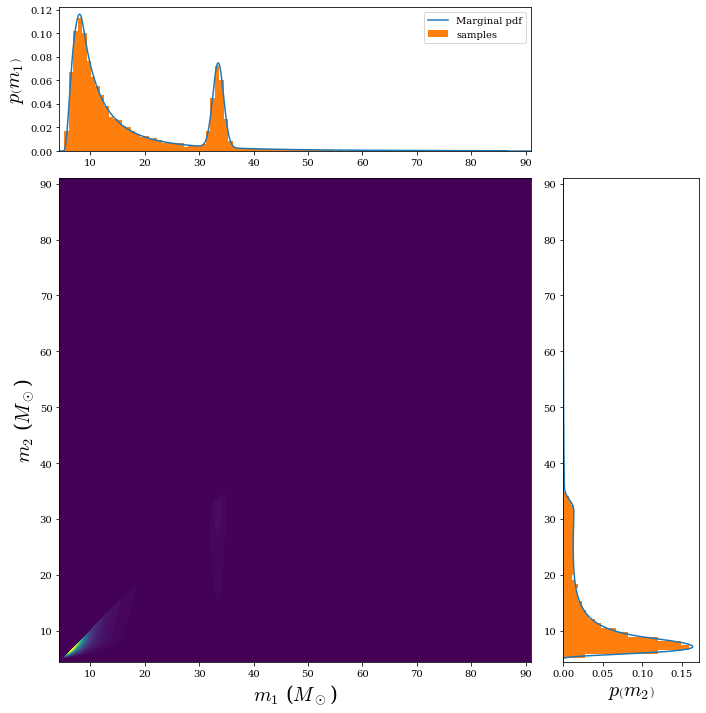

In [29]:

ms = np.logspace( np.log10(ml-ml/20), np.log10(mh+mh/20), 2000 )
M1S, M2S = np.meshgrid(ms, ms, indexing='ij')



PSNORM = np.where( M2S <= M1S, pp_norm(M1S, M2S) , 0) 


pm1NORM = np.trapz(PSNORM, M2S, axis=1)
pm2NORM = np.trapz(PSNORM, M1S, axis=0)



pm1NORM /= np.trapz(pm1NORM, ms)
pm2NORM /= np.trapz(pm2NORM, ms)


fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4)
joint_ax = fig.add_subplot(grid[1:,:-1])
m1_ax = fig.add_subplot(grid[0, :-1], sharex=joint_ax)
m2_ax = fig.add_subplot(grid[1:, -1], sharey=joint_ax)
    
x = joint_ax.contourf(M1S, M2S, PSNORM, cmap='viridis', levels=100)

m1_ax.plot(ms, pm1NORM, label='Marginal pdf')
_ = m1_ax.hist(m1sMD, bins=100, density=True, label='samples')
m1_ax.legend()
#m1_ax.set_yscale('log')

m2_ax.plot(pm2NORM, ms, label='Marginal pdf')
m2_ax.hist(m2sMD, bins=100, density=True, orientation='horizontal')
#m2_ax.legend()
#m2_ax.set_xscale('log')
    
joint_ax.set_xlabel(r'$m_1$ ($M_\odot$)', fontsize=20)
joint_ax.set_ylabel(r'$m_2$ ($M_\odot$)', fontsize=20)
    
m1_ax.set_ylabel(r'$p\left( m_1 \right)$', fontsize=20)
m2_ax.set_xlabel(r'$p\left( m_2 \right)$', fontsize=20)
    
plt.tight_layout()

# Computing the population function

In [33]:
# Now we can evaluate the population funtction.


m1 = np.array([30., ])
m2 = np.array([20., ])
z = np.array([1.5, ])

Lambda = lambdaBase

# m1, m2, z, spins, Lambda, Tobs, dL=None

logdN = allPopsMD.log_dN_dm1zdm2zddL( m1, m2, z, [], Lambda, 1., )

print(logdN)

[-1.81527604]


# Loading data

Each data release (O1-O2, O3a) has a specific class that inherits from the abstract class ABSData. 
A pre-defined function load_data is also available in sample.models .

Here we show how to load O1-O2 data

In [34]:
from dataStructures.O1O2data import O1O2Data, O1O2InjectionsData
from dataStructures.mockData import GWMockInjectionsData

In [74]:
# We can provide a dictionary of events to use or not use. In this case we specify to exclude GW170817 which is a BNS

events = {'use': None,
          'not_use': ['GW170817', ] }

# Injections qvqilqble for snr_th = 10, 11, 12
snr_th = 11

In [75]:
fname_data = os.path.join(Globals.dataPath, 'O1O2')
O1O2 = O1O2Data(fname_data, events_use=events, nSamplesUse=None, SNR_th=snr_th )


allData = [O1O2, ] # One can add here other datasets in the list

FAR th in LVC data: 1.0
In the O1O2 data we have the following BBH events, total 10 (excluding ['GW170817']):
['GW170729', 'GW151226', 'GW170809', 'GW170104', 'GW170608', 'GW170814', 'GW151012', 'GW170818', 'GW150914', 'GW170823']
Using only events with SNR>11 (round to 1 decimal digit)
Excluded the following events with SNR<11: 
['GW170729', 'GW151012']
8 events remaining.
Using only events with FAR<1.0
Excluded the following events with FAR>1.0: 
[]
8 events remaining.
Excluding BBH events : 
['GW170817']
Loading data...
Reading data from GW151226
Field weights_bin does not appear in this type.
Number of samples in LVC data: 52252
Reading data from GW170809
Field weights_bin does not appear in this type.
Number of samples in LVC data: 14802
Reading data from GW170104
Field weights_bin does not appear in this type.
Number of samples in LVC data: 24972
Reading data from GW170608
Field weights_bin does not appear in this type.
Number of samples in LVC data: 6448
Reading data from GW1708

#### O2 injections

In [76]:
# LVC injections
fname_inj  = os.path.join(fname_data, 'injections_O1O2an_spin.h5' )
InjDataO2_LVC = O1O2InjectionsData(fname_inj, )


Removing factor of 1/2 for each spin dimension from p_draw...
Re-weighting p_draw to go to detector frame quantities...
Number of total injections: 71000000.0
Number of injections that pass first threshold: 8472
Max redshift of injections: 1.1662752223838337
Obs time: 0.4556164383561644 yrs


In [77]:
# Injections generated with MGCosmoPop
fname_inj_1  = os.path.join(fname_data, 'injections_O1O2_IMRPhenomPv2_30k_alpha-11_beta-075_lamb-4_snr'+str(snr_th),'selected.h5' )

InjDataO2_mock = GWMockInjectionsData(fname_inj_1,  nInjUse=None,  Tobs=(48.3+118)/365.)

Loading injections...
Dropping 0 points with exactly equal masses
Max redshift of injections assuming Planck 15 cosmology: 1.128052420121763 redshift
Number of total injections: 726200000
Number of detected injections: 30006
Obs time: 0.4556164383561644


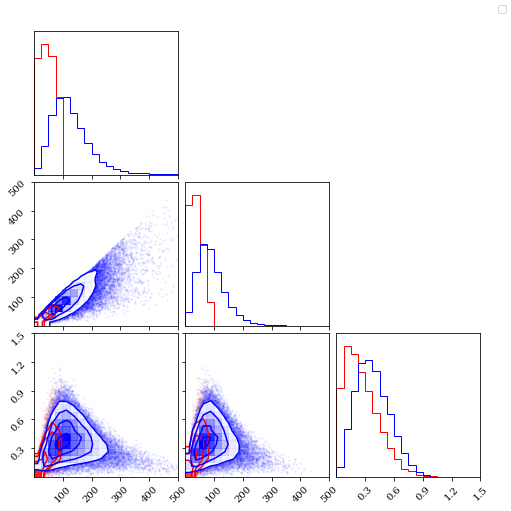

In [78]:
zs = myCosmo.z_from_dLGW_fast(InjDataO2_mock.dL, 67.74, 0.3075, -1, 1.0, 0)
m1s = InjDataO2_mock.m1z/(1+zs)
m2s = InjDataO2_mock.m2z/(1+zs)

zsLVC = myCosmo.z_from_dLGW_fast(InjDataO2_LVC.dL, 67.74, 0.3075, -1, 1.0, 0)
m1sLVC = InjDataO2_LVC.m1z/(1+zsLVC)
m2sLVC = InjDataO2_LVC.m2z/(1+zsLVC)


fig = corner.corner(np.array([m1sLVC, m2sLVC, zsLVC]).T, range=[(0,500), (0,500), (0,1.5)],  color='red', label='LVC', hist_kwargs=dict(density=True))
fig = corner.corner(np.array([m1s, m2s, zs]).T, range=[(0,500), (0,500), (0,1.5)],color='blue', label='MGCosmoPop', fig=fig, hist_kwargs=dict(density=True))


fig.legend(loc='upper right');

#### Expected detections in O1-O2

In [79]:
params_fixed_O2 = {        'w0': -1. , 
                        'Xi0':1.,
                        'Om': 0.311,
                    'R0':20,   'alphaRedshift':1.5,  'betaRedshift':2, 'zp':2,
                    'alpha1': 1.6, 'alpha2': 5.6, 'beta': 1.4, 'deltam': 4.8, 'ml': 4, 
                       'mh': 80, 'b': 0.43
    }



params_fixed_O2 ={allPopsMD.params[i]:lambdaBase[i] for i in range(len(allPopsMD.params))}


params_fixed_O2['mh'] = 50
params_fixed_O2['alphaRedshift'] = 1.5

allPopsMD.set_values(params_fixed_O2)


cosmo basevalues: {'H0': 67.74, 'Om': 0.3075, 'w0': -1, 'Xi0': 1, 'n': 1.91}
Setting value of H0 to 67.74 in Cosmo
Setting value of Om to 0.3075 in Cosmo
Setting value of w0 to -1 in Cosmo
Setting value of Xi0 to 1 in Cosmo
Setting value of n to 1.91 in Cosmo
Setting values in populations...
Setting value of R0 to 20 in AstroPhRateEvolution
Setting value of alphaRedshift to 1.5 in AstroPhRateEvolution
Setting value of betaRedshift to 4 in AstroPhRateEvolution
Setting value of zp to 2 in AstroPhRateEvolution
Setting value of lambdaPeak to 0.1 in PowerLawPlusPeakMass
Setting value of alpha to 2.62 in PowerLawPlusPeakMass
Setting value of beta to 1.26 in PowerLawPlusPeakMass
Setting value of deltam to 4.88 in PowerLawPlusPeakMass
Setting value of ml to 4.53 in PowerLawPlusPeakMass
Setting value of mh to 50 in PowerLawPlusPeakMass
Setting value of muMass to 33.49 in PowerLawPlusPeakMass
Setting value of sigmaMass to 1 in PowerLawPlusPeakMass
Setting value of R0 to 20 in AstroPopulation
Set

In [80]:
from posteriors.selectionBias import SelectionBiasInjections

selBias = SelectionBiasInjections( allPopsMD, [InjDataO2_mock, ], [ 'H0', ],  )


# We can compute the expected number of detections in the O1-O2 data-taking period, ant the associated MCC error

Lambda_test = [70., ]

Nexp, err, Neff = selBias.Ndet( Lambda_test, verbose=True, )

print('Around %s detections expected in the O1-O2 data-taking period with this population model' %int(Nexp[0]) )


Around 5 detections expected in the O1-O2 data-taking period with this population model


/Users/mancarel/Dropbox/Local/Physics_projects/MGCosmoPop/MGCosmoPop/notebooks/../population/allPopulations.py:84: RuntimeWarning: divide by zero encountered in log
  logN += np.log(popRate) #pop.log_dR_dm1dm2(m1, m2, z, spins, LambdaPop)


# Likelihood and posterior evaluation

In [81]:
from posteriors.prior import Prior
from posteriors.likelihood import HyperLikelihood
from posteriors.posterior import Posterior
from posteriors.selectionBias import SelectionBiasInjections

In [82]:
# We specify the prior limits
priorLimits = { 'H0': (10, 200),  
               'Xi0': (0.1, 10) ,
                'Om': (0.05, 1.),
                'w0': (-3., 0.),
               'n':(0.,10.),
               
               
                'R0': (0., 1e02), 
               'lambdaRedshift': (-15, 15),
               
                'alphaRedshift': (0., 12.),
               'betaRedshift': (0., 6.),
               'zp':(0., 4.),
               
               
               
               'alpha': (1.5, 12. ),
               'beta': (-4, 12 ), 
                'ml': (2, 50),
               'sl':( 0.01 , 1),
               'mh':( 50, 200),
               'sh':(0.01, 1 ),
               
               
               'alpha1': (1.5, 12),                          
               'alpha2': (1.5, 12), 
               'deltam':  (0, 10),

               'b':  (0, 1) ,
               
               'muEff':(-1, 1.),
                'sigmaEff':(0.01, 1.),
                'muP':(0.01, 1.),
                'sigmaP':(0.01, 1.),
                
                # PLpeak mass
                'lambdaPeak': (0., 1.), 'muMass':(20., 50.), 'sigmaMass':(0.4, 10.)
               
               }


priorNames = {'H0' : 'flat',
              'Xi0': 'flatLog',
              'Om': 'flat',
               'w0': 'flat',
              'n':'flat',
              
               'R0': 'flat',
              'lambdaRedshift': 'flat',
              
              'alphaRedshift': 'flat',
               'betaRedshift': 'flat',
               'zp':'flat',
              
              'alpha': 'flat',
               'beta': 'flat', 
               'ml': 'flat',
               'sl':'flat',
               'mh':'flat',
               'sh':'flat',
               
               'alpha1':'flat',
               'alpha2':'flat',
               'deltam':'flat',
               'b':'flat',
               
               'muEff':'flat',
               'sigmaEff':'flat',
                'muP':'flat',
                'sigmaP':'flat',
              'lambdaPeak':'flat',  'muMass':'flat', 'sigmaMass':'flat'
               
               }


# Specify the parameters names on which to do the inference
params_inference = [ 'H0', ]



In [83]:
allPopsMD.get_base_values(allPopsMD.params)

[67.74,
 0.3075,
 -1,
 1,
 1.91,
 20,
 1.5,
 4,
 2,
 0.1,
 2.62,
 1.26,
 4.88,
 4.53,
 50,
 33.49,
 1]

In [84]:
# Instantiate Prior object
myPrior = Prior(priorLimits, params_inference, priorNames, priorParams=None)
  
# Instantiate likelihood
myLik = HyperLikelihood(allPopsMD, allData, params_inference, verbose=True, safety_factor=30 )



In [85]:


# Instantiate selection bias

selBias = SelectionBiasInjections( allPopsMD, [InjDataO2_mock, ], params_inference,  )


# We can compute the expected number of detections in the O1-O2 data-taking period, ant the associated MCC error

Lambda_test = [70., ]

Nexp, err, Neff = selBias.Ndet( Lambda_test, verbose=True, )

print('Around %s detections expected in the O1-O2 data-taking period with this population model with my injections' %int(Nexp[0]) )


Around 5 detections expected in the O1-O2 data-taking period with this population model with my injections


In [86]:
# Instantiate posterior

myPost = Posterior(myLik, myPrior, selBias, verbose=True )


#### Example: posterior probability for $H_0$, assuming all the astrophysical parameters are known

In [87]:
H0grid = np.linspace(20, 200, 30)
postGrid = [myPost.logPosterior([val, ]) for val in H0grid]

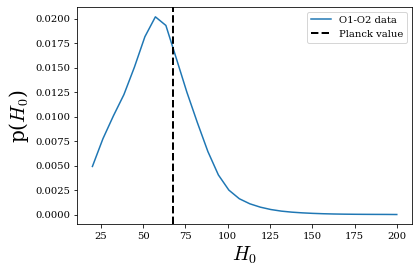

In [88]:
plt.plot(H0grid, np.exp(postGrid)/np.trapz(np.exp(postGrid), H0grid), label='O1-O2 data' );


plt.xlabel(r'$H_0$', fontsize=20);
plt.ylabel(r'p($H_0$)', fontsize=20);
plt.axvline(67.74, color='k', ls='--', lw=2, label='Planck value');
plt.legend();